Plug-and-Play PGM Demosaicing
===============================

This example demonstrates the use of class [pgm.ppp.PPP](http://sporco.rtfd.org/en/latest/modules/sporco.pgm.ppp.html#sporco.pgm.ppp.PPP) for solving a raw image demosaicing problem via the PGM Plug and Play Priors (PPP) algorithm [[29]](http://sporco.rtfd.org/en/latest/zreferences.html#kamilov-2017-plugandplay).

In [1]:
from __future__ import print_function
from builtins import input, range

import numpy as np

from bm3d import bm3d_rgb
try:
    from colour_demosaicing import demosaicing_CFA_Bayer_Menon2007
except ImportError:
    have_demosaic = False
else:
    have_demosaic = True

from sporco.pgm.ppp import PPP
from sporco.interp import bilinear_demosaic
from sporco import metric
from sporco import util
from sporco import plot
plot.config_notebook_plotting()

Define demosaicing forward operator and its transpose.

In [2]:
def A(x):
    """Map an RGB image to a single channel image with each pixel
    representing a single colour according to the colour filter array.
    """

    y = np.zeros(x.shape[0:2])
    y[1::2, 1::2] = x[1::2, 1::2, 0]
    y[0::2, 1::2] = x[0::2, 1::2, 1]
    y[1::2, 0::2] = x[1::2, 0::2, 1]
    y[0::2, 0::2] = x[0::2, 0::2, 2]
    return y


def AT(x):
    """Back project a single channel raw image to an RGB image with zeros
    at the locations of undefined samples.
    """

    y = np.zeros(x.shape + (3,))
    y[1::2, 1::2, 0] = x[1::2, 1::2]
    y[0::2, 1::2, 1] = x[0::2, 1::2]
    y[1::2, 0::2, 1] = x[1::2, 0::2]
    y[0::2, 0::2, 2] = x[0::2, 0::2]
    return y

Define baseline demosaicing function. If package [colour_demosaicing](https://github.com/colour-science/colour-demosaicing) is installed, use the demosaicing algorithm of Menon et al. (doi:10.1109/TIP.2006.884928), othewise use simple bilinear demosaicing.

In [3]:
if have_demosaic:
    def demosaic(cfaimg):
        return demosaicing_CFA_Bayer_Menon2007(cfaimg, pattern='BGGR')
else:
    def demosaic(cfaimg):
        return bilinear_demosaic(cfaimg)

Load reference image.

In [4]:
img = util.ExampleImages().image('kodim23.png', scaled=True,
                                 idxexp=np.s_[160:416,60:316])

Construct test image constructed by colour filter array sampling and adding Gaussian white noise.

In [5]:
np.random.seed(12345)
s = A(img)
rgbshp = s.shape + (3,)  # Shape of reconstructed RGB image
rgbsz = s.size * 3       # Size of reconstructed RGB image
nsigma = 2e-2            # Noise standard deviation
sn = s + nsigma * np.random.randn(*s.shape)

Define data fidelity term for PPP problem.

In [6]:
def f(x):
    return 0.5 * np.linalg.norm((A(x) - sn).ravel())**2

Define gradient of data fidelity term for PPP problem.

In [7]:
def gradf(x):
    return AT(A(x) - sn)

Define proximal operator of (implicit, unknown) regularisation term for PPP problem. In this case we use BM3D [[17]](http://sporco.rtfd.org/en/latest/zreferences.html#dabov-2008-image) as the denoiser, using the [code](https://pypi.org/project/bm3d) released with [[33]](http://sporco.rtfd.org/en/latest/zreferences.html#makinen-2019-exact).

In [8]:
bsigma = 3.3e-2  # Denoiser parameter

def proxg(x, L):
    return bm3d_rgb(x, bsigma)

Construct a baseline solution and initaliser for the PPP solution by BM3D denoising of a simple bilinear demosaicing solution. The `3 * nsigma` denoising parameter for BM3D is chosen empirically for best performance.

In [9]:
imgb = bm3d_rgb(demosaic(sn), 3 * nsigma)

Set algorithm options for PPP solver, including use of bilinear demosaiced solution as an initial solution.

In [10]:
opt = PPP.Options({'Verbose': True, 'RelStopTol': 1e-3,
                   'MaxMainIter': 20, 'L': 6.8e-1, 'X0': imgb})

Create solver object and solve, returning the the demosaiced image ``imgp``.

In [11]:
b = PPP(img.shape, f, gradf, proxg, opt=opt)
imgp = b.solve()

Itn   FVal      Rsdl    
------------------------


   0  1.44e+01  1.33e+00


   1  1.39e+01  6.37e-01


   2  1.37e+01  3.64e-01


   3  1.35e+01  2.13e-01


   4  1.35e+01  1.51e-01


   5  1.34e+01  1.29e-01


   6  1.34e+01  1.15e-01


   7  1.34e+01  1.04e-01


   8  1.34e+01  9.99e-02


   9  1.35e+01  9.71e-02


  10  1.35e+01  9.66e-02


  11  1.35e+01  9.65e-02


  12  1.35e+01  9.83e-02


  13  1.35e+01  9.60e-02


  14  1.35e+01  9.40e-02


  15  1.35e+01  9.44e-02


  16  1.35e+01  9.50e-02


  17  1.35e+01  9.44e-02


  18  1.35e+01  9.60e-02


  19  1.35e+01  9.54e-02
------------------------


Display solve time and demosaicing performance.

In [12]:
print("PPP PGM solve time:        %5.2f s" % b.timer.elapsed('solve'))
print("Baseline demosaicing PSNR:  %5.2f dB" % metric.psnr(img, imgb))
print("PPP demosaicing PSNR:       %5.2f dB" % metric.psnr(img, imgp))

PPP PGM solve time:        71.57 s
Baseline demosaicing PSNR:  35.98 dB
PPP demosaicing PSNR:       36.59 dB


Display reference and demosaiced images.

/nh/research/brendt/CondaHome/miniconda3/envs/py37/lib/python3.7/site-packages/mpldatacursor/convenience.py:160: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cbook.iterable(axes):
/nh/research/brendt/CondaHome/miniconda3/envs/py37/lib/python3.7/site-packages/mpldatacursor/datacursor.py:140: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cbook.iterable(artists):


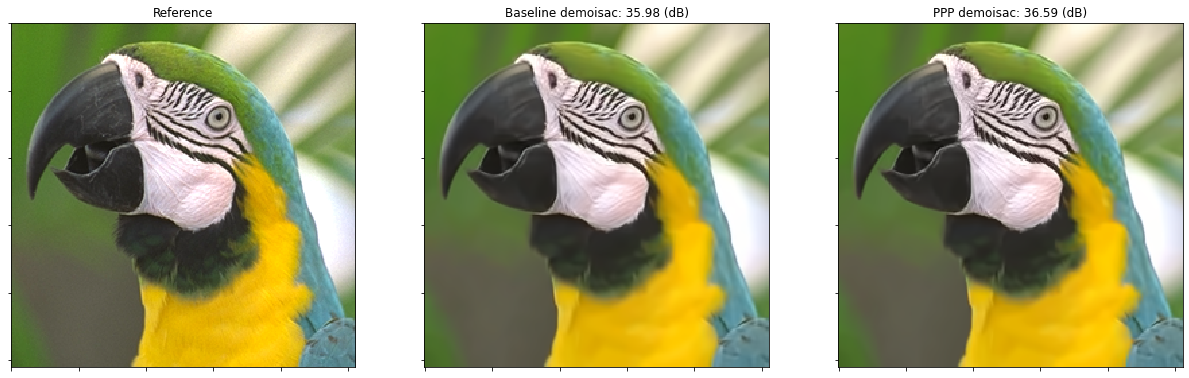

In [13]:
fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=True,
                        figsize=(21, 7))
plot.imview(img, title='Reference', fig=fig, ax=ax[0])
plot.imview(imgb, title='Baseline demoisac: %.2f (dB)' %
            metric.psnr(img, imgb), fig=fig, ax=ax[1])
plot.imview(imgp, title='PPP demoisac: %.2f (dB)' %
            metric.psnr(img, imgp), fig=fig, ax=ax[2])
fig.show()